# Cross-validation studies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd

from src.dataset.data import Dataset
from src.features.build_features import *
from src.features.utils import convert_category_cols_lgb
from src.model.train import *

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from category_encoders import OneHotEncoder

pd.options.display.max_rows = 50
pd.options.display.max_columns = None

%matplotlib inline

In [4]:
ds = Dataset()
ds.load_dataset()

In [5]:
build_date_features(ds)

In [6]:
X_train = ds.X_train
X_test = ds.X_test
y_train = ds.y_train.values.ravel()

In [7]:
X_train.head(5)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,has_identity,DT,DT_M,DT_W,DT_D,DT_hour,DT_day_week,DT_day
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,None,None,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,0,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,None,None,None,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0

In [8]:
X_train['DT_M'].value_counts()

12    137321
15    101632
13     92585
17     89326
14     86021
16     83655
Name: DT_M, dtype: int64

In [9]:
pd.crosstab(X_train['DT_M'], y_train)

col_0,0,1
DT_M,,
12,133771,3550
13,88880,3705
14,82574,3447
15,97613,4019
16,80827,2828
17,86212,3114


In [12]:
X_fraud = pd.DataFrame(data={'date': X_train['DT'].values, 'isFraud': y_train})
X_fraud = X_fraud.set_index('date')
X_fraud.head()

,isFraud
date,
2017-12-01 00:00:00,0
2017-12-01 00:00:01,0
2017-12-01 00:01:09,0
2017-12-01 00:01:39,0
2017-12-01 00:01:46,0


In [13]:
X_fraud_daily = X_fraud.resample('D').agg({'count': 'sum', 'fraud_rate': 'mean'})

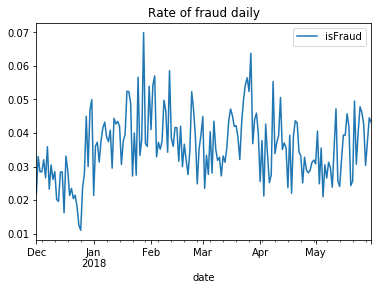

In [14]:
fig, ax = plt.subplots()
ax = X_fraud_daily['fraud_rate'].plot(ax=ax)
plt.title('Rate of fraud daily')
plt.show()

We define reported chargeback on card, user account, associated email address and transactions directly linked to these attributes as fraud transaction (isFraud=1); If none of above is found after 120 days, then we define as legit (isFraud=0). This is applied to both train and test. The date time for provided dataset is long enough from now to believe that label is reliable.

Whatever

In [15]:
result = seasonal_decompose(X_fraud_daily['fraud_rate'], model='additive')

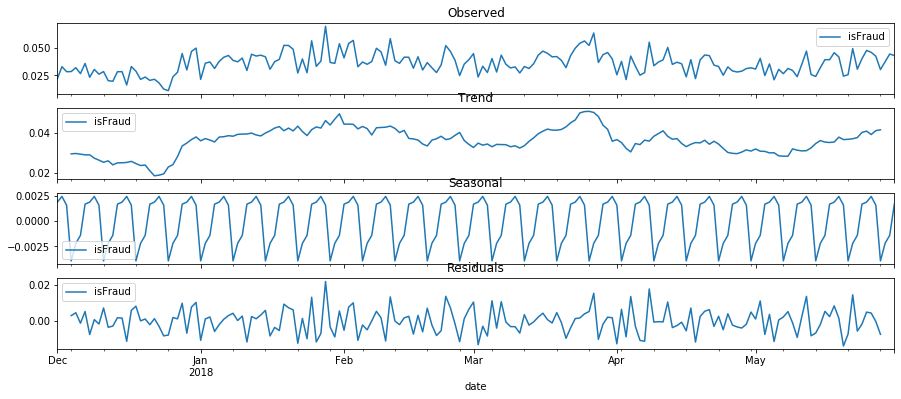

In [16]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(15,6))
result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)

ax1.title.set_text('Observed')
ax2.title.set_text('Trend')
ax3.title.set_text('Seasonal')
ax4.title.set_text('Residuals')
plt.show()

## Inspect by ProductCD and TransactionAmt

In [17]:
X_ProductCD = X_train[["DT", "ProductCD"]]
X_ProductCD['isFraud'] = y_train
X_ProductCD['DT'] = X_train['DT']
X_ProductCD = X_ProductCD.set_index('DT')

In [18]:
X_ProductCD = OneHotEncoder(cols=['ProductCD']).fit_transform(X_ProductCD)

In [19]:
X_ProductCD.head()

,ProductCD_1,ProductCD_2,ProductCD_3,ProductCD_4,ProductCD_5,isFraud
DT,,,,,,
2017-12-01 00:00:00,1,0,0,0,0,0
2017-12-01 00:00:01,1,0,0,0,0,0
2017-12-01 00:01:09,1,0,0,0,0,0
2017-12-01 00:01:39,1,0,0,0,0,0
2017-12-01 00:01:46,0,1,0,0,0,0


In [20]:
for col in [c for c in X_ProductCD if "ProductCD" in c]:
    X_ProductCD[col] = X_ProductCD[col] * y_train

In [21]:
X_ProductCD[X_ProductCD['isFraud']==1].head(5)

,ProductCD_1,ProductCD_2,ProductCD_3,ProductCD_4,ProductCD_5,isFraud
DT,,,,,,
2017-12-01 00:56:00,1,0,0,0,0,1
2017-12-01 01:03:13,0,0,1,0,0,1
2017-12-01 01:04:06,0,0,1,0,0,1
2017-12-01 01:04:55,0,0,1,0,0,1
2017-12-01 01:16:26,0,0,1,0,0,1


In [22]:
X_ProductCD_daily = X_ProductCD.resample('D').sum()

In [23]:
X_ProductCD_daily.head()

,ProductCD_1,ProductCD_2,ProductCD_3,ProductCD_4,ProductCD_5,isFraud
DT,,,,,,
2017-12-01,59,3,29,9,12,112.0
2017-12-02,61,4,53,1,4,123.0
2017-12-03,51,12,24,2,3,92.0
2017-12-04,56,7,43,5,4,115.0
2017-12-05,64,11,45,0,7,127.0
